# (Replicating in R) Estimating COVID-19's  𝑅𝑡  in Real-Time
[Ramnath Vaidyanathan](https://twitter.com/ramnath_vaidya)  - April 16

[Kevin Systrom](https://twitter.com/kevin) published a [really interesting article](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) on estimating $R_t$, the measure known as effective reproduction number. In his article, Kevin describes this number as:

> The number of people who become infected per infectious person at time  𝑡

Kevin was kind enough to publish his code as a [notebook on github](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb). I wanted to do more with his model, and also apply it to other countries. However, given that I am a lot more proficient in [R](https://cran.r-project.org/), I wanted to first replicate his results in R.

Before you read the rest of this post, I would strongly recommend that you read the [original article](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) to get a more detailed sense of the modeling approach used, as this post is more focused on the code. 

All credit for the modeling approach and code goes to Kevin 👍. This notebook is my humble attempt at translating his model into R. Any mistakes that remain are solely mine.

__UPDATE__: 

[David Robinson](https://twitter.com/drob) pointed out some clever ways to simplify the tidyverse code in this post, especially around removing the need for nesting. It makes the code a lot cleaner. Thanks Dave! 

## Bettencourt & Ribeiro

We will use the same approach outlined by Kevin in his article, which uses the paper by [Bettencourt & Ribeiro](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) as its underlying basis. 

### Modeling arrivals

The first step is to model the 'arrival' process of infections. A popular choice for the distribution of arrivals amongst statisticians is the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Accordingly, if we let $\lambda$ represent the average rate of infections per day, then the probability that we are likely to see $k$ new cases on a day, is given by 

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Given this setup, we can construct the probability distribution of new cases  for a set of $\lambda$s. Before we can start writing code, we need to load the `tidyverse` set of packages, and customize some plotting options (plot dimensions, plotting them etc). You can feel free to skip reading this section, as it is not critical to the narrative, but do make sure to execute the code.

### Packages & options

In [ ]:
# Load packages
library(tidyverse)

# Plot options

## Jupyter notebooks use the repr package to create viewable representations
## of R objects (https://github.com/IRkernel/repr). I am updating the default
## plot dimensions to 12 x 6.
options(repr.plot.width = 12, repr.plot.height = 6)

## We will use ggplot2 for all plots. I am defining a custom theme here
## that mainly updates the backgrounds and legend position. We set this
## custom theme as the default, and also update the default for line size.
theme_custom <- function(base_size, ...){
  ggplot2::theme_gray(base_size = base_size, ...) +
  ggplot2::theme(
    plot.title = element_text(face = 'bold'),
    plot.subtitle = element_text(color = '#333333'),
    panel.background = element_rect(fill = "#EBF4F7"), 
    strip.background = element_rect(fill = "#33AACC"),
    legend.position = "bottom"
  )
}
ggplot2::theme_set(theme_custom(base_size = 20))
ggplot2::update_geom_defaults("line", list(size = 1.5))

# Utility functions

## We will use a utility function to display the head of dataframes.
## Note that we need this hack mainly to add the class 'dataframe' to 
## the tables that are printed. This should ideally be handled 
## by the `repr` package, and I will be sending a PR.
display_df <- function(x){
  d <- as.character(
    knitr::kable(x, format = 'html', table.attr = "class='dataframe'")
  )
  IRdisplay::display_html(d)
}

display_head <- function(x, n = 6){
   display_df(head(x, n))
}

display_random <- function(x, n = 6){
   display_df(dplyr::sample_n(x, n))
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Poisson distribution

We can use the `crossing` function from `purrr` to compute probability densities across a combination of $k$s and $\lambda$s.

In [ ]:
# Number of new cases observed in a day
k = 0:69

# Arrival rate of new infections per day
lambda = c(10, 20, 30, 40)

poisson_densities = crossing(lambda = lambda, k = k) %>%
  mutate(p = dpois(k, lambda))

display_head(poisson_densities)

lambda,k,p
10,0,0.0000454
10,1,0.0004540
10,2,0.0022700
10,3,0.0075667
10,4,0.0189166
10,5,0.0378333


We can visualize these probabilities using `ggplot2`. Note how we make use of [expression](https://www.rdocumentation.org/packages/base/topics/expression) to render math symbols in plots. You can read more about this in the documentation for [plotmath](https://www.rdocumentation.org/packages/grDevices/topics/plotmath).

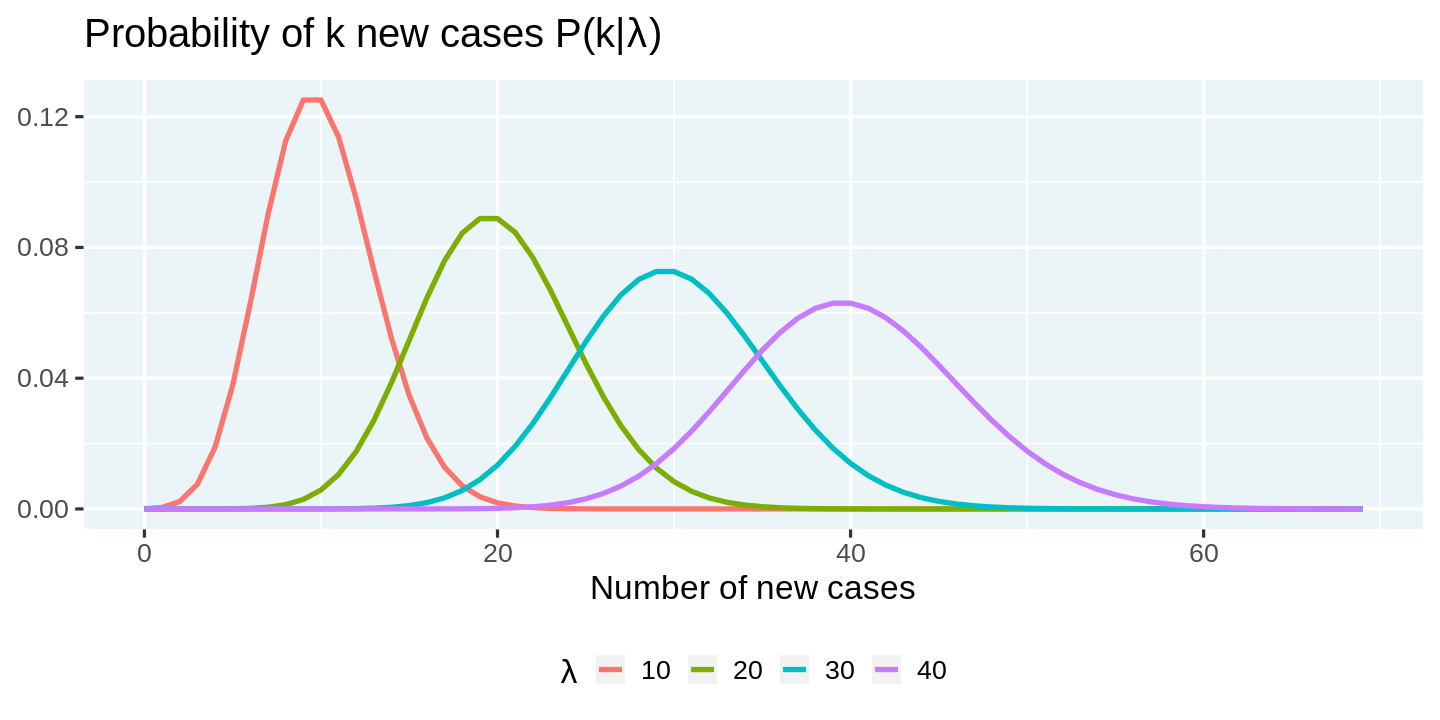

In [ ]:
poisson_densities %>% 
  # We convert lambda to a factor so that each line gets a discrete color
  mutate(lambda = factor(lambda)) %>% 
  ggplot(aes(x = k, y = p, color = lambda)) +
  geom_line() +
  labs(
    title = expression(paste("Probability of k new cases P(k|", lambda, ")")),
    x = 'Number of new cases',
    y = NULL,
    color = expression(lambda)
  )

### Poisson likelihood

Modeling the arrival process as a Poisson distribution allows us to predict the distribution of new cases in a day as a function of the arrival rate $\lambda$. However, in reality, we only observe the number of arrivals. So the key question now is how do we go from the observed number of arrivals to get a sense of the distribution of $\lambda$. Thankfully, the answer to this question is simple.

$$L(\lambda| k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

The distribution of $\lambda$ over k is called the **likelihood** function, and it has the same mathematical exression as the **probability mass function** we used earlier. We can visualize the likelihood function by fixing the number of new cases observed (k), and computing the likelihood function over a range of values of $\lambda$. 


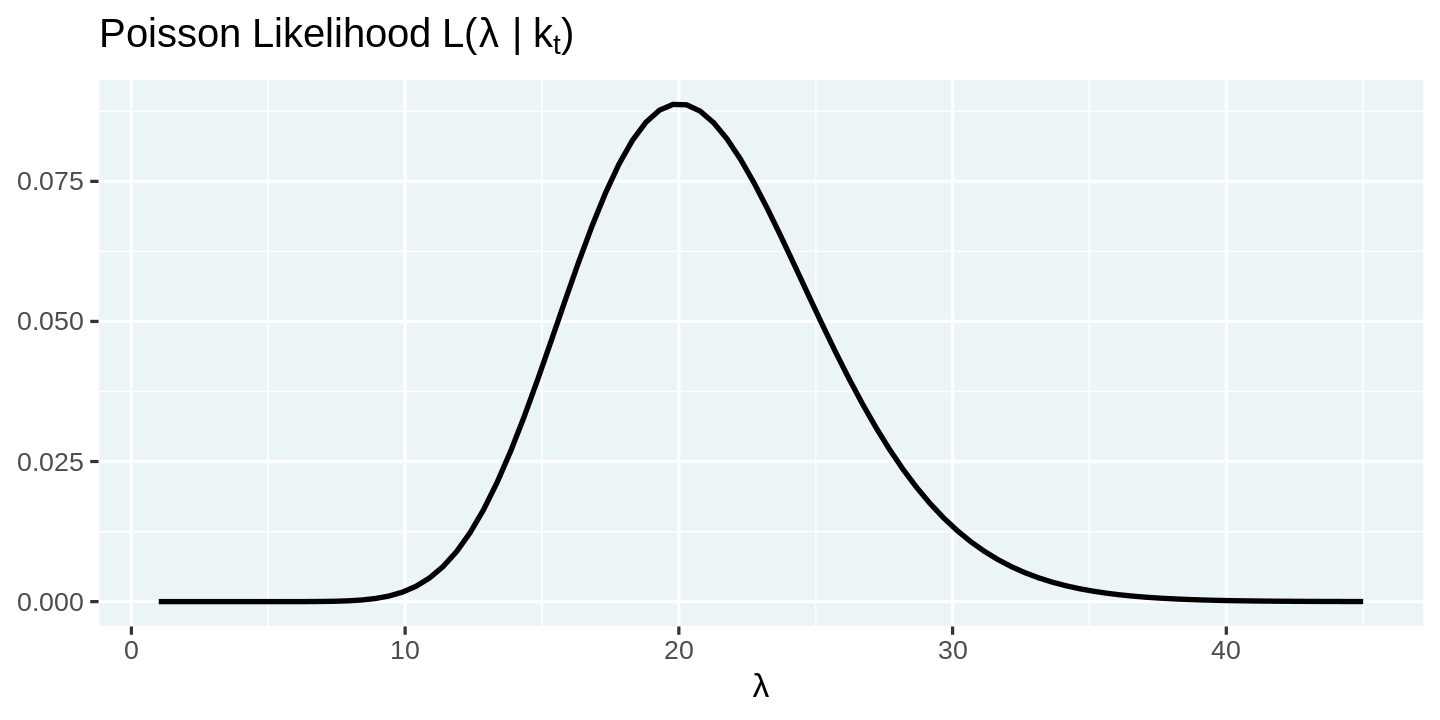

In [ ]:
# Number of new cases observed in a day
k = 20

# Arrival rates of new infections per day
lambdas = seq(1, 45, length = 90)

# Compute likelihood and visualize them
tibble(lambda = lambdas, p = dpois(k, lambdas)) %>% 
  ggplot(aes(x = lambda, y = p)) +
  geom_line(color = 'black') +
  labs(
    title = expression(paste("Poisson Likelihood L(", lambda, " | k"[t], ")")),
    x = expression(lambda),
    y = NULL
  ) 

### Connecting $\lambda$ and $R_t$

All this is good, but you might be wondering where is the effective infection rate, $R_t$, we talked about in the beginning. How is it related to the arrival rate $\lambda$. According to this paper by [Bettencourt & Ribeiro](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185), the relationship is rather simple

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

Note that $\gamma$ here is the reciprocal of the serial interval ([about 4 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)), and $k_{t-1}$ is the number of new cases observed in the time interval $t-1$. 

We can use this expression for $\lambda$ and reformulate the likelihood function in terms of $R_t$. 


$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Before we move on, let us set up some core parameters.

In [ ]:
# r_t_range is a vector of possible values for R_t
R_T_MAX = 12
r_t_range = seq(0, R_T_MAX, length = R_T_MAX*100 + 1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# New cases by day
k =  c(20, 40, 55, 90)

We can use the `crossing` function once again to create a data frame with different combinations of $r_t$ and $k$, and then compute the likelihoods as defined in the expressions.

In [ ]:
likelihoods <- tibble(day = seq_along(k) - 1, k = k) %>%
  crossing(r_t = r_t_range) %>%
  group_by(r_t) %>%
  mutate(lambda = lag(k) * exp(GAMMA * (r_t - 1))) %>%
  ungroup() %>%
  mutate(likelihood_r_t = dpois(k, lambda)) %>%
  # Ignore the 0th day
  filter(day > 0)

display_random(likelihoods)

day,k,r_t,lambda,likelihood_r_t
2,55,5.96,138.22454,0.0000000
3,90,7.70,293.63373,0.0000000
3,90,5.56,171.97226,0.0000000
2,55,4.19,88.79936,0.0000312
3,90,11.11,688.71889,0.0000000
2,55,0.36,34.08575,0.0002424


We can now plot the likelihood conditional on the number of new cases observed.

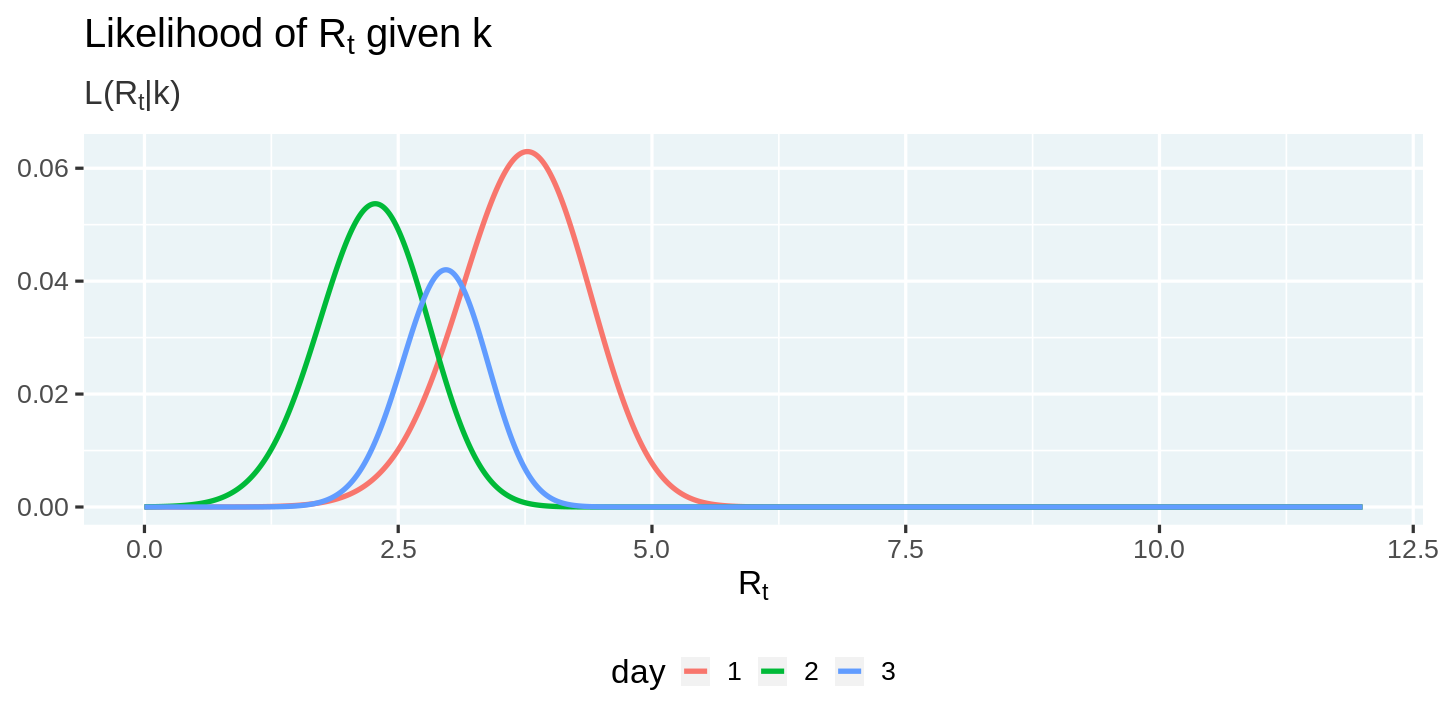

In [ ]:
likelihoods %>%  
  ggplot(aes(x = r_t, y = likelihood_r_t, color = factor(day))) +
  geom_line() +
  labs(
    title = expression(paste("Likelihood of R"[t], " given k")),
    subtitle = expression(paste("L(R"[t], "|k)")),
    x = expression("R"[t]),
    y = NULL, color = 'day'
  )

### Estimating $R_t$

We have made good progress in linking the number of new cases, $k$, and the effective infection rate, $R_t$. However, we still don't have a tangible approach to estimate its values from the time series of observed new cases. Here is where the ubiquitous [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) comes extremely handy. Bettencourt & Ribeiro express the probability distribution of $R_t$ as

$$ P(R_t|k_t)=\frac{P(R_t)\cdot\mathcal{L}(k_t|R_t)}{P(k_t)} $$

Kevin unpacks this complex equation in much simpler terms.

> This says that, having seen  𝑘  new cases, we believe the distribution of  𝑅𝑡  is equal to:
> - The __prior__ beliefs of the value of $P(R_t)$ without the data ...
> - times the __likelihood__ of seeing $k$ new cases given $R_t$ ...
> - divided by the probability of seeing this many cases in general.

If we use the posterior probability of the previous period, $P(R_{t-1} | k_{t-1})$, as the prior, $P(R_t)$, for the current period, then we can rewite the previous equation as:

$$ P(R_t|k_t) \propto P(R_{t-1}|k_{t-1})\cdot\mathcal{L}(k_t|R_t) $$


Iterating across periods all the way back to $t = 0$, we get

$$ P(R_t|k_t) \propto P(R_0) \cdot {\displaystyle \prod^{T}_{t=0}}\mathcal{L}(k_t|R_t) $$

With a uniform prior $P(R_0)$, this reduces to:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=0}}\mathcal{L}\left(k_t|R_t\right) $$

We can now use this mathematical expression to compute the posterior from the likelihoods. Once again, we use the vectorized function `cumprod` to generate posteriors for all days at once, and then normalize it.



In [ ]:
posteriors <- likelihoods %>%
  group_by(r_t) %>% 
  arrange(day) %>% 
  mutate(posterior = cumprod(likelihood_r_t)) %>% 
  group_by(k) %>% 
  mutate(posterior = posterior / sum(posterior)) %>%
  ungroup()

display_random(posteriors)

day,k,r_t,lambda,likelihood_r_t,posterior
2,55,3.37,72.34016,0.0055623,0.0040354
3,90,7.72,295.10558,0.0000000,0.0000000
1,40,11.05,246.71462,0.0000000,0.0000000
2,55,4.50,95.95501,0.0000017,0.0000008
1,40,10.07,193.10465,0.0000000,0.0000000
2,55,8.36,251.86153,0.0000000,0.0000000


We can now visualize the posterior distribution.

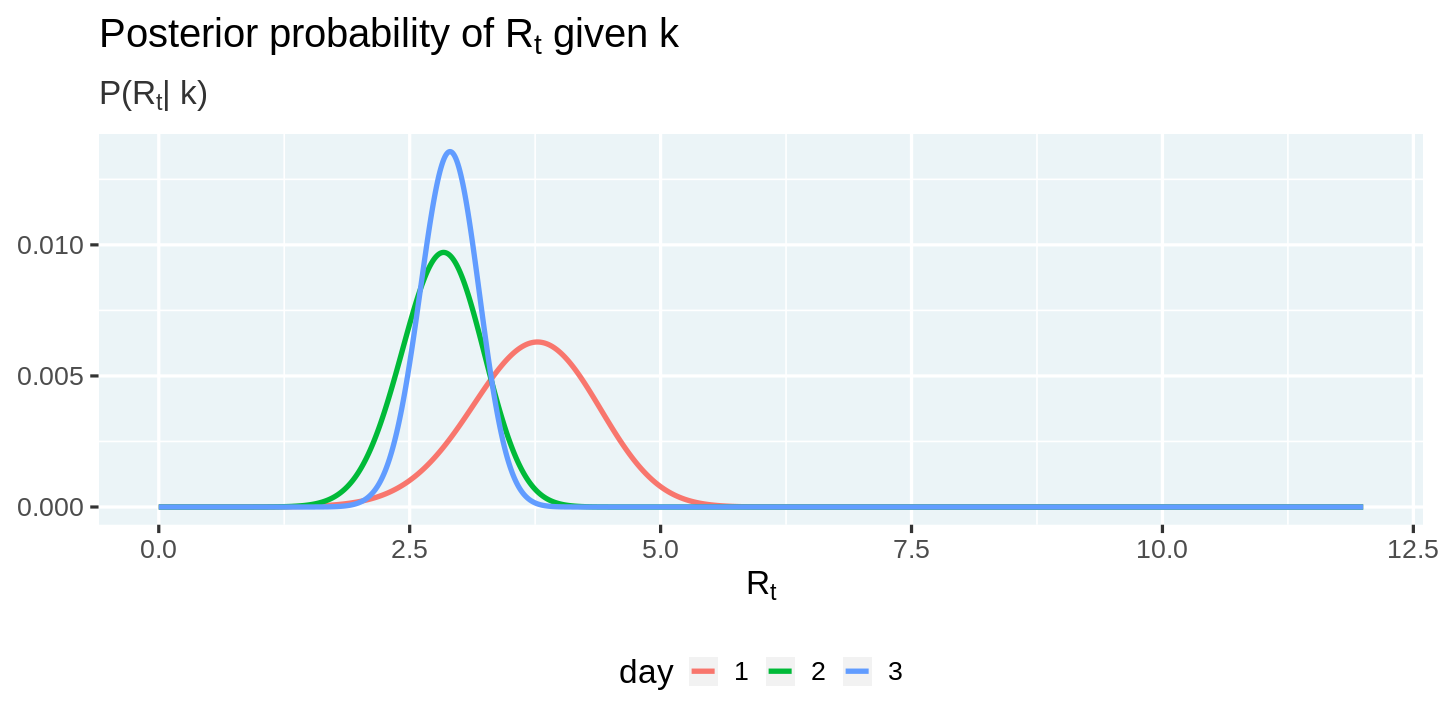

In [ ]:
posteriors %>% 
  ggplot(aes(x = r_t, y = posterior, color = factor(day))) +
  geom_line() +
  labs(
    title = expression(paste("Posterior probability of R"[t], " given k")),
    subtitle = expression(paste("P(R"[t], "| k)")),
    x = expression("R"[t]), y = NULL, color = 'day'
  )

These posteriors now allow us to answer the all important question:

> What is the most likely value of $R_t$ each day?

While estimating any quantity, it is very important to provide a sense of the error surrounding the estimate. A popular way of doing this is to use [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval). 

> Another way of summarizing a distribution is the highest density interval, which summarizes the distribution by specifying an interval that spans most of the distribution, say 95% of it, such that every point inside the interval has higher credibility than any point outside the interval.


In his article, Kevin implemented a brute force algorithm to compute HDI. R users are more fortunate that there is already a package, `HDInterval`, out there with an implementation 🎉.

We will now estimate the most likely value of $R_t$, and the highest density interval surrounding it. Since the `HDInterval::hdi` function only works with a vector of random values from a distribution, and we only estimated the posterior probabilities, we will need to simulate random values of $R_t$ using the posterior probabilities in order to compute the highest-density intervals.

In [ ]:
# Install and load HDInterval package
install.packages("HDInterval")
library(HDInterval)

# Compute the most likely value of r_t and the highest-density interval
estimates <- posteriors %>% 
  group_by(day) %>% 
  summarize(
    r_t_simulated = list(sample(r_t_range, 10000, replace = TRUE, prob = posterior)),
    r_t_most_likely = r_t_range[which.max(posterior)]
  ) %>% 
  mutate(
    r_t_lo = map_dbl(r_t_simulated, ~ hdi(.x)[1]),
    r_t_hi = map_dbl(r_t_simulated, ~ hdi(.x)[2])
  ) %>% 
  select(-r_t_simulated)

display_head(estimates)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



day,r_t_most_likely,r_t_lo,r_t_hi
1,3.77,2.45,4.93
2,2.84,2.00,3.61
3,2.90,2.28,3.44


We can visualize these estimates and the uncertaintly surrounding them using a line plot with ribbons.

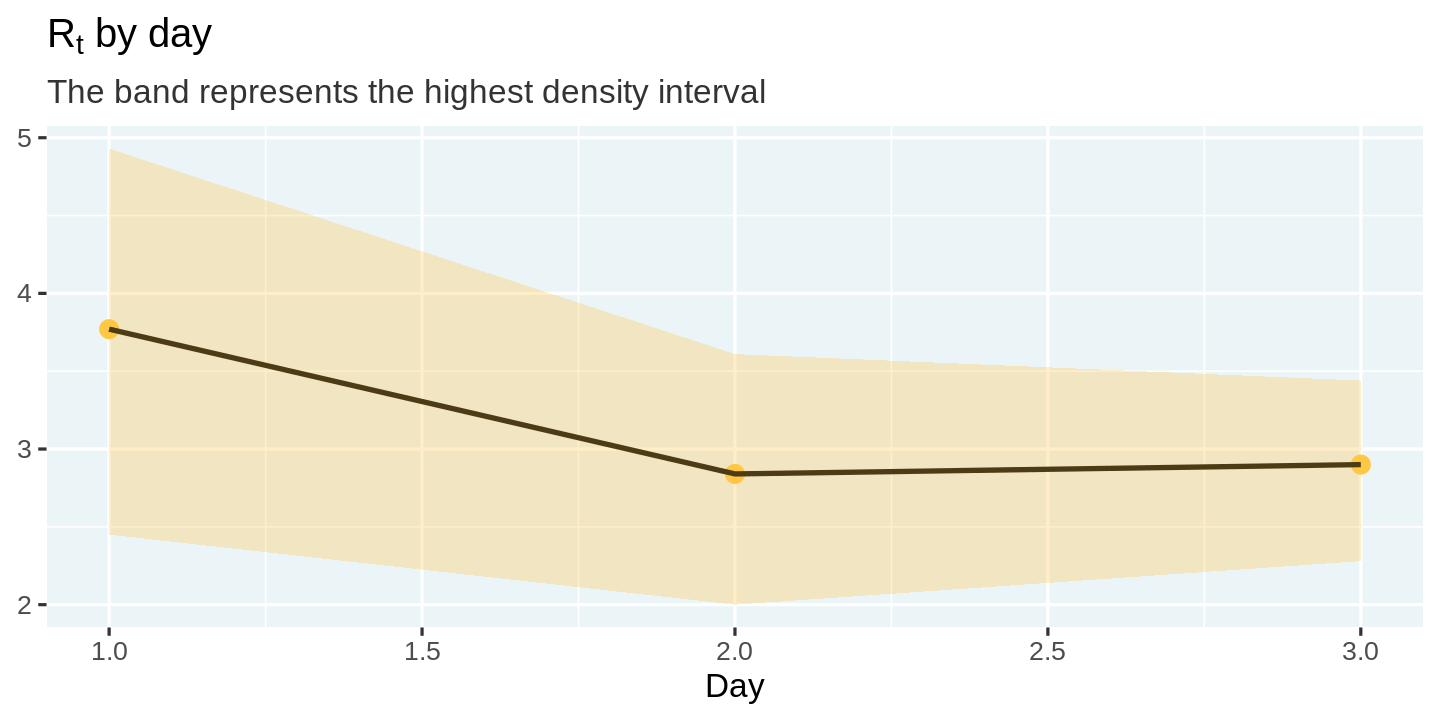

In [ ]:
estimates %>% 
  ggplot(aes(x = day, y = r_t_most_likely)) +
  geom_point(color = "#ffc844", size = 5) +
  geom_line(color = 'black') +
  geom_ribbon(aes(ymin = r_t_lo, ymax = r_t_hi), fill = "#ffc844", alpha = 0.3) +
  labs(
    title = expression(paste('R'[t], ' by day')),
    subtitle = "The band represents the highest density interval",
    x = 'Day', y = NULL
  )

While Bettencourt and Ribeiro's approach works fine, Kevin points out a practical problem with it (that is also noted in the paper), that it is possible for the **posterior to get stuck and asympotically approach 1**, due to its inability to forget the times with a high $R_t$. 

To counter this problem, Kevin suggests the following approach.

> So, I propose to only incorporate the last $m$ days of the likelihood function. By doing this, the algorithm's prior is built based on the recent past which is a much more useful prior than the entire history of the epidemic. So this simple, but important change leads to the following:
> $$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}\mathcal{L}\left(k_t|R_t\right) $$

We will use this modification to estimate the values of $R_t$ across different states in the US.

## Application to US Data

It is now time to take all this machinery we built and apply it on COVID data from US states to estimate the effective infection rate, $R_t$. Let us begin by fetching the data. We will use the COVID dataset for the US constructed by the New York Times.

In [ ]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
covid_cases <- readr::read_csv(url)
 
display_head(covid_cases)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  state = col_character(),
  fips = col_character(),
  cases = col_double(),
  deaths = col_double()
)



date,state,fips,cases,deaths
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0
2020-01-25,California,06,1,0


### Smooth new cases

The first step is to prepare the data by computing the number of new cases every day, and smoothing it over a rolling window. The smoothing is essential to account for lags in reporting. The lag has been found to be especially pronounced over weekends. 

Following Kevin's approach, I utilize a gaussian smoother with a 7-day rolling window.

Note that we will implement all data processing steps as standalone functions. While this adds some overhead, it will allow us to compose these steps cleanly, and also apply them across one or more states, which will come very handy. 

We will apply these steps to one selected state, so it is easier to look at the results and make sense out of them. I have selected New York, but feel free to switch it to a state of your choice!

In [ ]:
# Install the smoother package
install.packages("smoother")

#' Compute new cases and smooth them
smooth_new_cases <- function(cases){
  cases %>% 
    arrange(date) %>%
    mutate(new_cases = c(cases[1], diff(cases))) %>% 
    mutate(new_cases_smooth = round(
      smoother::smth(new_cases, window = 7, tails = TRUE)
    )) %>%
    select(state, date, new_cases, new_cases_smooth)
}

state_selected <- "New York"
covid_cases %>% 
  filter(state == state_selected) %>%
  smooth_new_cases() %>%
  display_head()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



state,date,new_cases,new_cases_smooth
New York,2020-03-01,1,1
New York,2020-03-02,0,2
New York,2020-03-03,1,4
New York,2020-03-04,9,9
New York,2020-03-05,11,15
New York,2020-03-06,22,23


Let us plot the raw values as well as the smoothed values for `new_cases` so we can visualize what the smoothing process is doing. 

🎩 It is always good practice to visualize the results after you make some data transformations. This allows you to build intuition and also sanity check that your transformation is doing what you intended it to do!

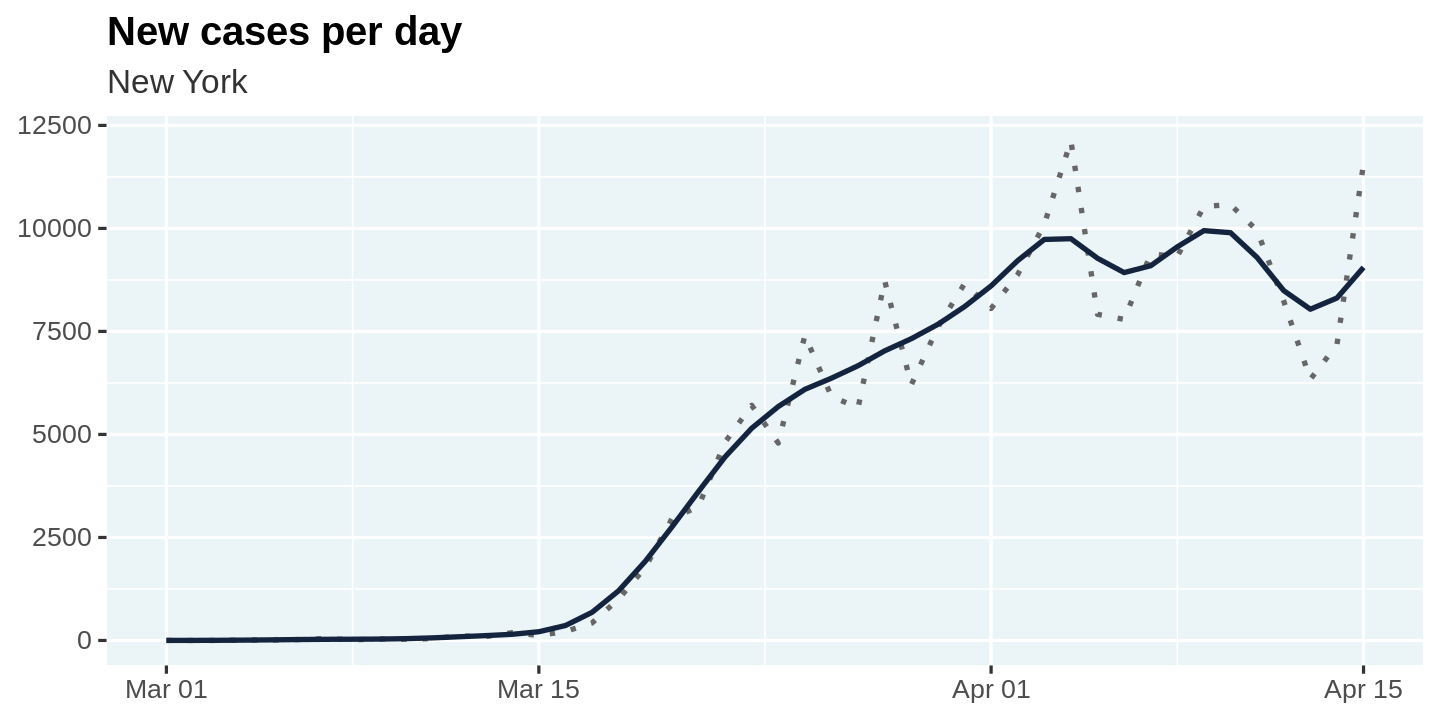

In [ ]:
plot_new_cases <- function(cases){
  cases %>%
    ggplot(aes(x = date, y = new_cases)) +
    geom_line(linetype = 'dotted', color = 'gray40') +
    geom_line(aes(y = new_cases_smooth), color = "#14243e") +
    labs(
      title = "New cases per day",
      subtitle = unique(cases$state),
      x = NULL, y = NULL
    )
}

covid_cases %>% 
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  plot_new_cases()

### Compute Likelihoods

The second step is to compute the likelihoods. We will use the same approach we followed previously, but with one notable difference. We will compute log-likelihoods instead of the likelihoods. This will make it easier to smooth them over a rolling window to apply the modification suggested by Kevin, of only using the latest $m$ intervals to compute $R_t$.

In [ ]:
compute_likelihood <- function(cases){
  likelihood <- cases %>%
    filter(new_cases_smooth > 0) %>% 
    arrange(date) %>%
    crossing(r_t = r_t_range) %>% 
    group_by(r_t) %>% 
    mutate(lambda = lag(new_cases_smooth, 1) * exp(GAMMA * (r_t - 1))) %>%
    ungroup() %>%
    mutate(likelihood_r_t = dpois(new_cases_smooth, lambda, log = TRUE)) %>% 
    filter(date > min(date))
}
  
covid_cases %>% 
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  compute_likelihood() %>%
  display_random()

state,date,new_cases,new_cases_smooth,r_t,lambda,likelihood_r_t
New York,2020-04-07,9378,9094,3.68,17447.43080,-2433.461190
New York,2020-04-11,9946,9293,9.30,78809.18721,-49655.395246
New York,2020-03-08,17,30,8.56,185.34232,-103.334424
New York,2020-03-07,45,28,3.86,47.01629,-7.092199
New York,2020-04-10,10575,9895,10.48,106396.26366,-73004.763477
New York,2020-04-09,10536,9946,5.95,32929.04982,-11081.371393


### Compute Posteriors

The third step is to compute the posterior probabilities. Recall that 

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}\mathcal{L}\left(k_t|R_t\right) $$ 

We can rewrite this in terms of the log-likelihoods

$$ P(R_t|k_t) \propto {\displaystyle \exp \big( \sum^{T}_{t=T-m}}\log(\mathcal{L}\left(k_t|R_t\right)) \big) $$

We can use the `rollapplyr` function from the `zoo` package to compute a rolling 7-day sum of the log likelihoods, and then exponentiate it to compute the posterior. Finally, we normalize the posteriors to 1.0.


In [ ]:
compute_posterior <- function(likelihood){
  likelihood %>% 
    arrange(date) %>% 
    group_by(r_t) %>% 
    mutate(posterior = exp(
      zoo::rollapplyr(likelihood_r_t, 7, sum, partial = TRUE)
    )) %>% 
    group_by(date) %>% 
    mutate(posterior = posterior / sum(posterior, na.rm = TRUE)) %>% 
    # HACK: NaNs in the posterior create issues later on. So we remove them.
    mutate(posterior = ifelse(is.nan(posterior), 0, posterior)) %>%
    ungroup() %>%
    select(-likelihood_r_t)
}

covid_cases %>%
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  compute_likelihood() %>% 
  compute_posterior() %>%
  display_random()

state,date,new_cases,new_cases_smooth,r_t,lambda,posterior
New York,2020-03-25,7401,6094,5.61,1.797394e+04,0.0000000
New York,2020-03-02,0,2,0.68,9.231163e-01,0.0010363
New York,2020-03-07,45,28,11.48,3.159216e+02,0.0000000
New York,2020-04-09,10536,9946,8.34,5.985083e+04,0.0000000
New York,2020-03-11,44,63,1.28,4.719036e+01,0.0002923
New York,2020-03-31,8658,8101,5.28,2.236679e+04,0.0000000


Let us visualize the posterior probabilities we computed. Note how we set `alpha = 0.2` to reduce the amount of overplotting. This allows us to visualize the shifting posteriors.

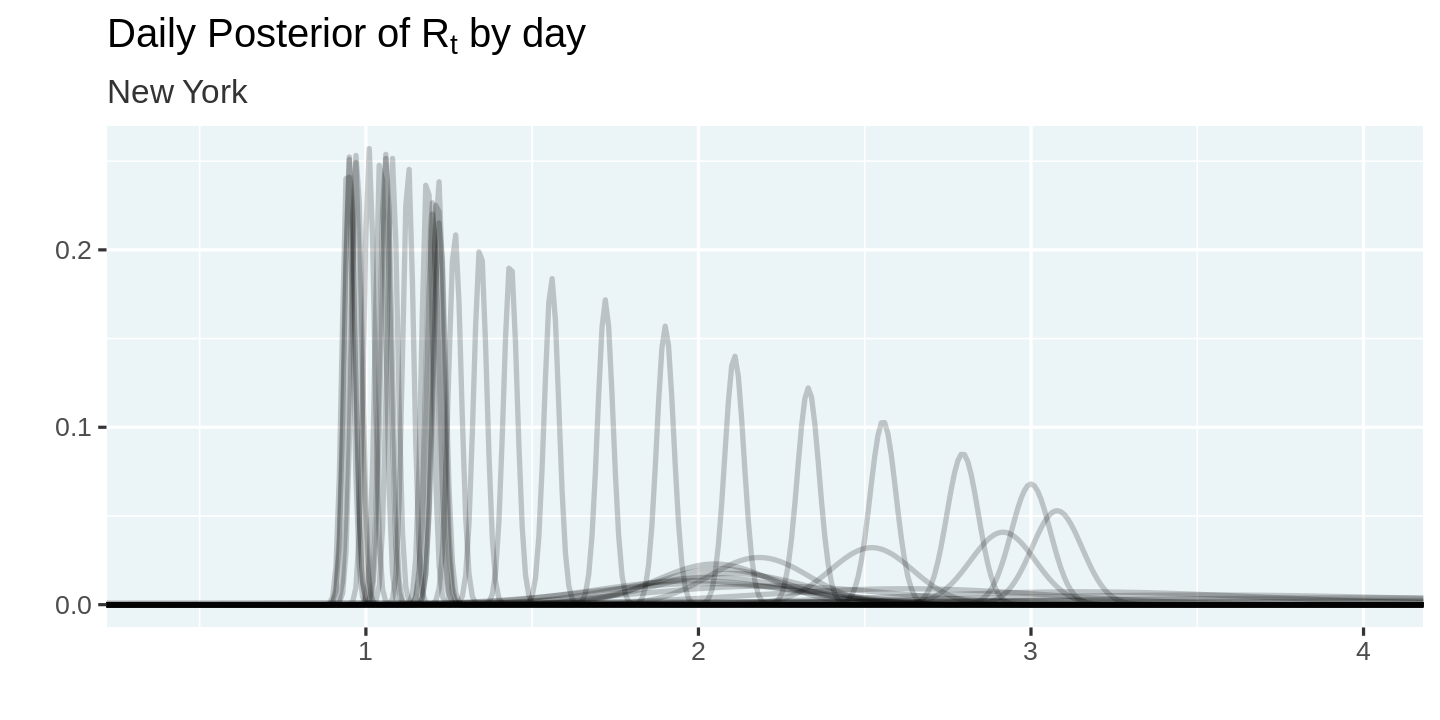

In [ ]:
plot_posteriors <- function(posteriors){
  posteriors %>% 
    ggplot(aes(x = r_t, y = posterior, group = date)) +
    geom_line(alpha = 0.2) +
    labs(
      title = expression(paste("Daily Posterior of R"[t], " by day")),
      subtitle = unique(posteriors$state),
      x = '',
      y = ''
    ) +
    coord_cartesian(xlim = c(0.4, 4)) +
    theme(legend.position = 'none')
}

covid_cases %>%
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  compute_likelihood() %>% 
  compute_posterior() %>% 
  plot_posteriors()

### Estimate Rt

The final step is to estimate the values of $R_t$ and the highest density intervals surrounding them. Recall that we need to simulate random values for $r_t$ using the posterior probabilities in order to apply the `HDIInterval::hdi` function to compute the highest density intervals.

In [ ]:
# Estimate R_t and a 95% highest-density interval around it
estimate_rt <- function(posteriors){
  posteriors %>% 
    group_by(state, date) %>% 
    summarize(
      r_t_simulated = list(sample(r_t_range, 10000, replace = TRUE, prob = posterior)),
      r_t_most_likely = r_t_range[which.max(posterior)]
    ) %>% 
    mutate(
      r_t_lo = map_dbl(r_t_simulated, ~ hdi(.x)[1]),
      r_t_hi = map_dbl(r_t_simulated, ~ hdi(.x)[2])
    ) %>% 
    select(-r_t_simulated) 
}
 
covid_cases %>%
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  compute_likelihood() %>% 
  compute_posterior() %>% 
  estimate_rt() %>%
  display_random()

state,date,r_t_most_likely,r_t_lo,r_t_hi
New York,2020-04-15,0.97,0.93,0.99
New York,2020-03-06,3.15,2.08,4.18
New York,2020-03-28,1.34,1.31,1.38
New York,2020-03-26,1.56,1.52,1.60
New York,2020-03-17,2.92,2.72,3.09
New York,2020-03-04,4.05,1.86,5.90


Finally, we come to the moment of truth! Let us visualize the estimated values of $R_t$

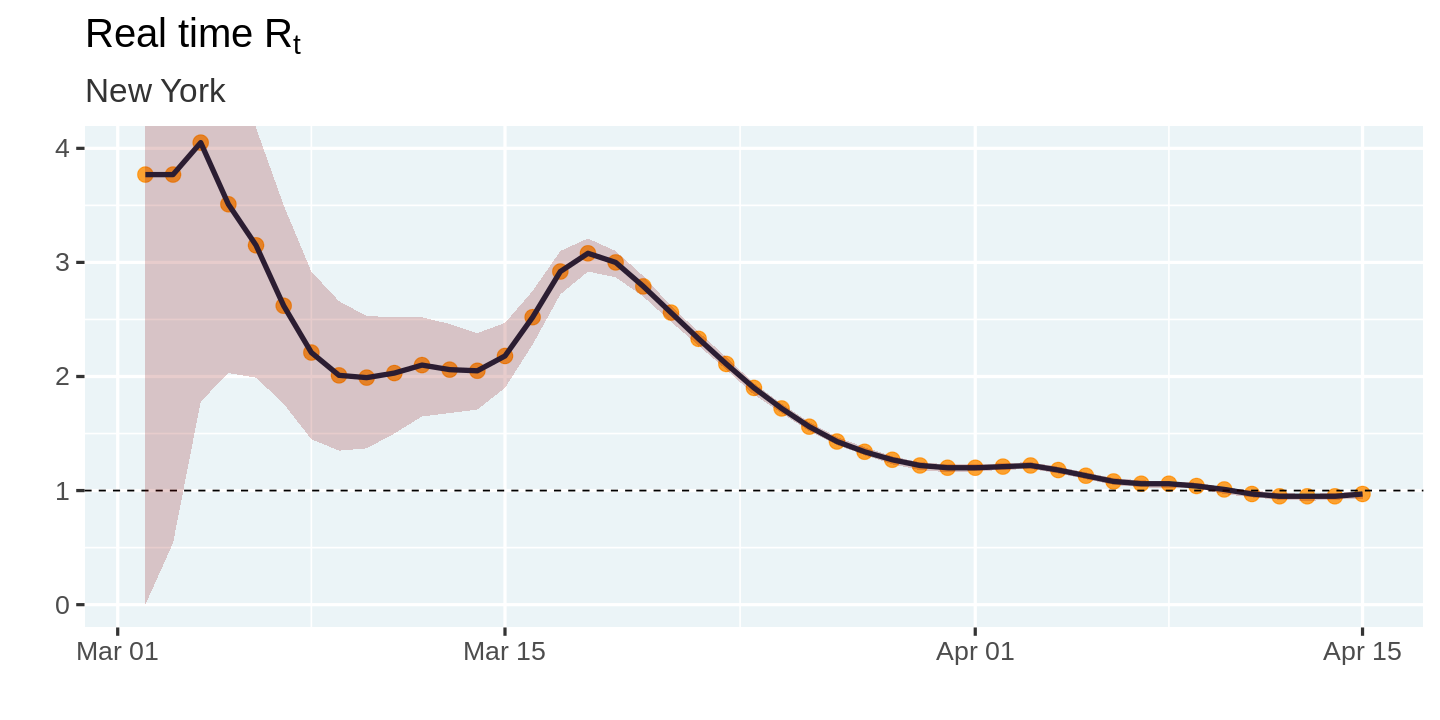

In [ ]:
plot_estimates <- function(estimates){
  estimates %>% 
    ggplot(aes(x = date, y = r_t_most_likely)) +
    geom_point(color = "darkorange", alpha = 0.8, size = 4) +
    geom_line(color = "#14243e") +
    geom_hline(yintercept = 1, linetype = 'dashed') +
    geom_ribbon(
      aes(ymin = r_t_lo, ymax = r_t_hi), 
      fill = 'darkred', 
      alpha = 0.2
    ) +
    labs(
      title = expression('Real time R'[t]), x = '', y = '',
      subtitle = unique(estimates$state)
    ) +
    coord_cartesian(ylim = c(0, 4))
}

covid_cases %>%
  filter(state == state_selected) %>% 
  smooth_new_cases() %>% 
  compute_likelihood() %>% 
  compute_posterior() %>% 
  estimate_rt() %>% 
  plot_estimates()

So how does this compare with the estimates from Kevin's article. It seems like the initial estimates in my model are off from Kevin's estimates. However, that could be a function of differences in the smoothing algorithm, or the large uncertainty surrounding the intial estimates. The overall shape of the curve and the peaks seem to match up pretty closely. Mission accomplished! 🎉

### Loop across all states

It is now time to loop across all states and compute these estimates. We can do this easily by grouping by `state`, splitting the data into one table per state, and using `purrr::map_df` to estimate $R_t$ for each state and combine them back into a single table.



In [ ]:
# ⚠️This function can take a couple of minutes to run
#   as it loops across all states
estimates_all <- covid_cases %>% 
  filter(date >= "2020-03-01") %>% 
  group_by(state) %>%
  # Ignore states that have not reached 100 infections
  filter(max(cases) > 100 ) %>% 
  group_split() %>% 
  map_df(~ {
    .x %>% 
      smooth_new_cases() %>% 
      compute_likelihood() %>% 
      compute_posterior() %>% 
      estimate_rt()
  }) %>%
  ungroup()

In [ ]:
estimates_all %>%
  display_random()

state,date,r_t_most_likely,r_t_lo,r_t_hi
Maryland,2020-04-07,1.49,1.33,1.62
Hawaii,2020-04-15,0.64,0.00,1.29
Massachusetts,2020-03-07,3.19,1.19,4.80
New York,2020-03-10,1.99,1.42,2.56
Connecticut,2020-03-15,2.56,1.08,3.90
Delaware,2020-03-31,1.42,0.86,1.92


We can now create a small multiples plot of the estimates across all states. The use of `ggplot2` makes this really easy and all we had to add was an extra line of code!

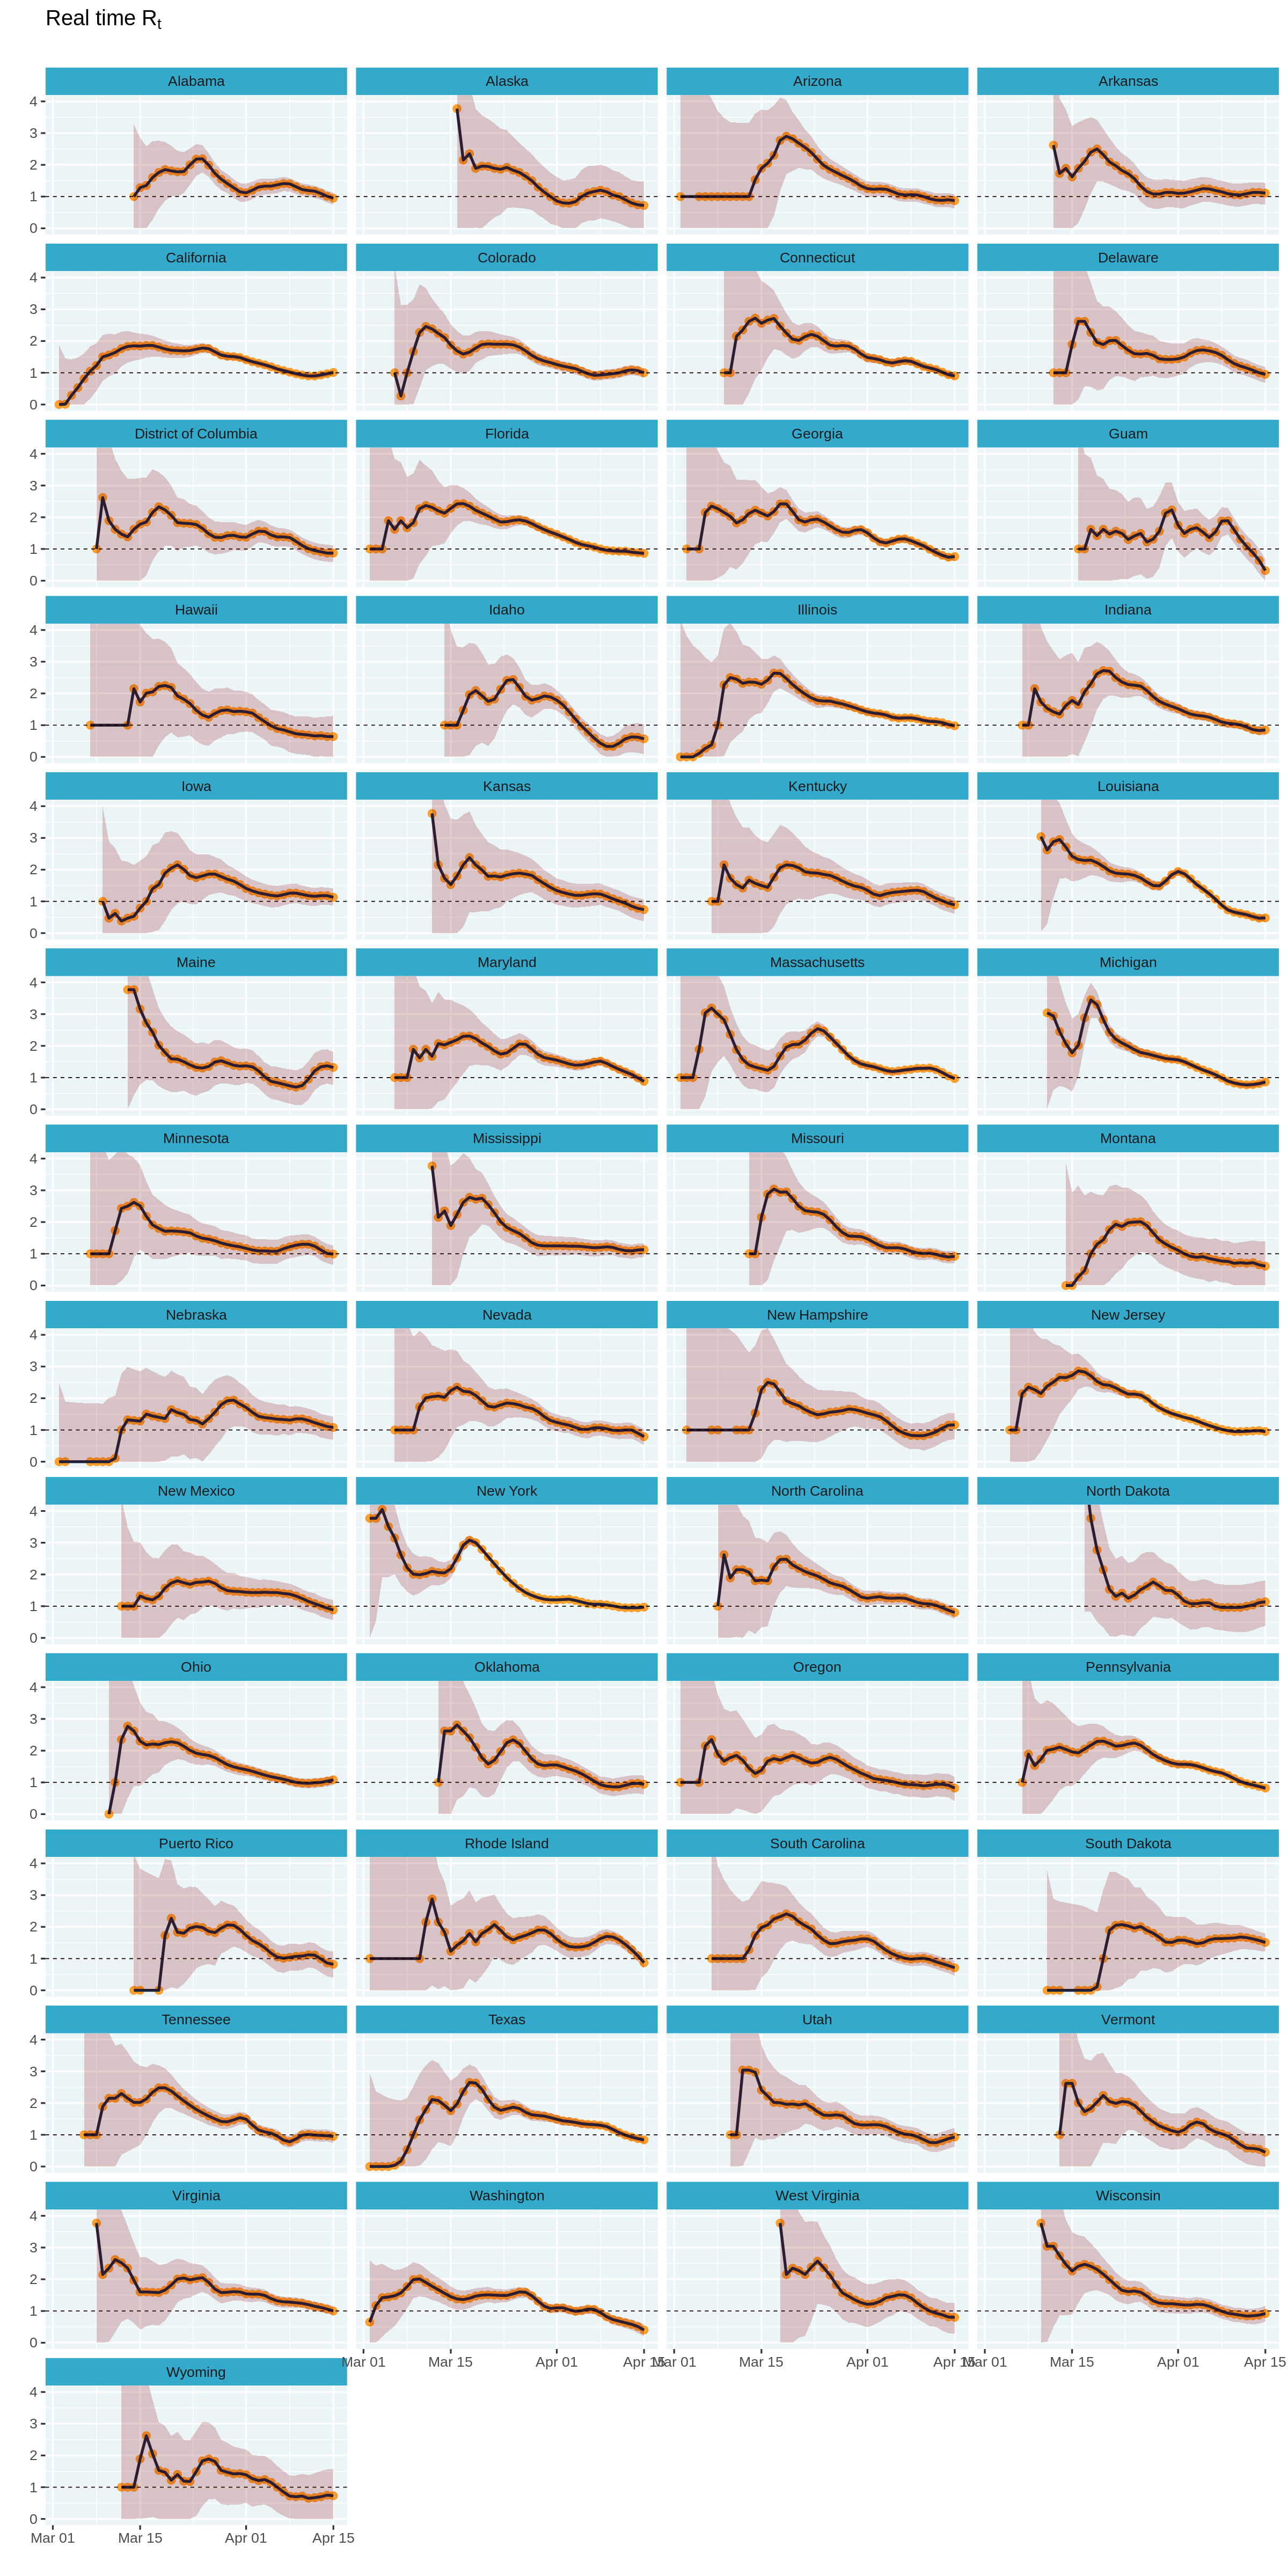

In [ ]:
# Increase plot height and width
options(repr.plot.height = 40, repr.plot.width = 20)
estimates_all %>% 
  plot_estimates() +
  facet_wrap(~ state, ncol = 4) +
  labs(subtitle = "")

# Reset plot dimensions
options(repr.plot.height = 12, repr.plot.width = 8)

While the small multiples plot is perfect, it is hard to navigate to a state based on its geographic location. What if we could plot each state close to its geographic location?

Thankfully, Ryan Hafen has  created the `geofacet` package that allows us to lay out these small multiples on a geographic grid with a single line of code. 

⚠️ Unfortunately, I was not able to install the `geofacet` package on colab (I suspect it is because of system dependencies required by the `sf` package), and hence the code chunk below will fail to execute. I have included a saved version of the plot I generated locally, so you can get a sense of how it looks.

In [ ]:
# ⚠️ CAUTION: This code will error on colab
# options(repr.plot.height = 40, repr.plot.width = 20)
# estimates_all %>% 
#  mutate(state = state.abb[match(state, state.name)]) %>%
#  plot_estimates() +
#  geofacet::facet_geo(~ state, ncol = 4) +
#  labs(subtitle = "") +
#  theme(strip.text = element_text(hjust = 0))
# options(repr.plot.height = 12, repr.plot.width = 8)

![geofacet](https://i.imgur.com/9Op2GLt.png)

Finally, let us recreate the plot in Kevin's article that orders the states based on the most likely estimated value of $R_t$, and colors them based on the state of lockdown. 

⚠️ Please note that this is a purely descriptive plot and one cannot draw any conclusions on the efficacy of lockdowns

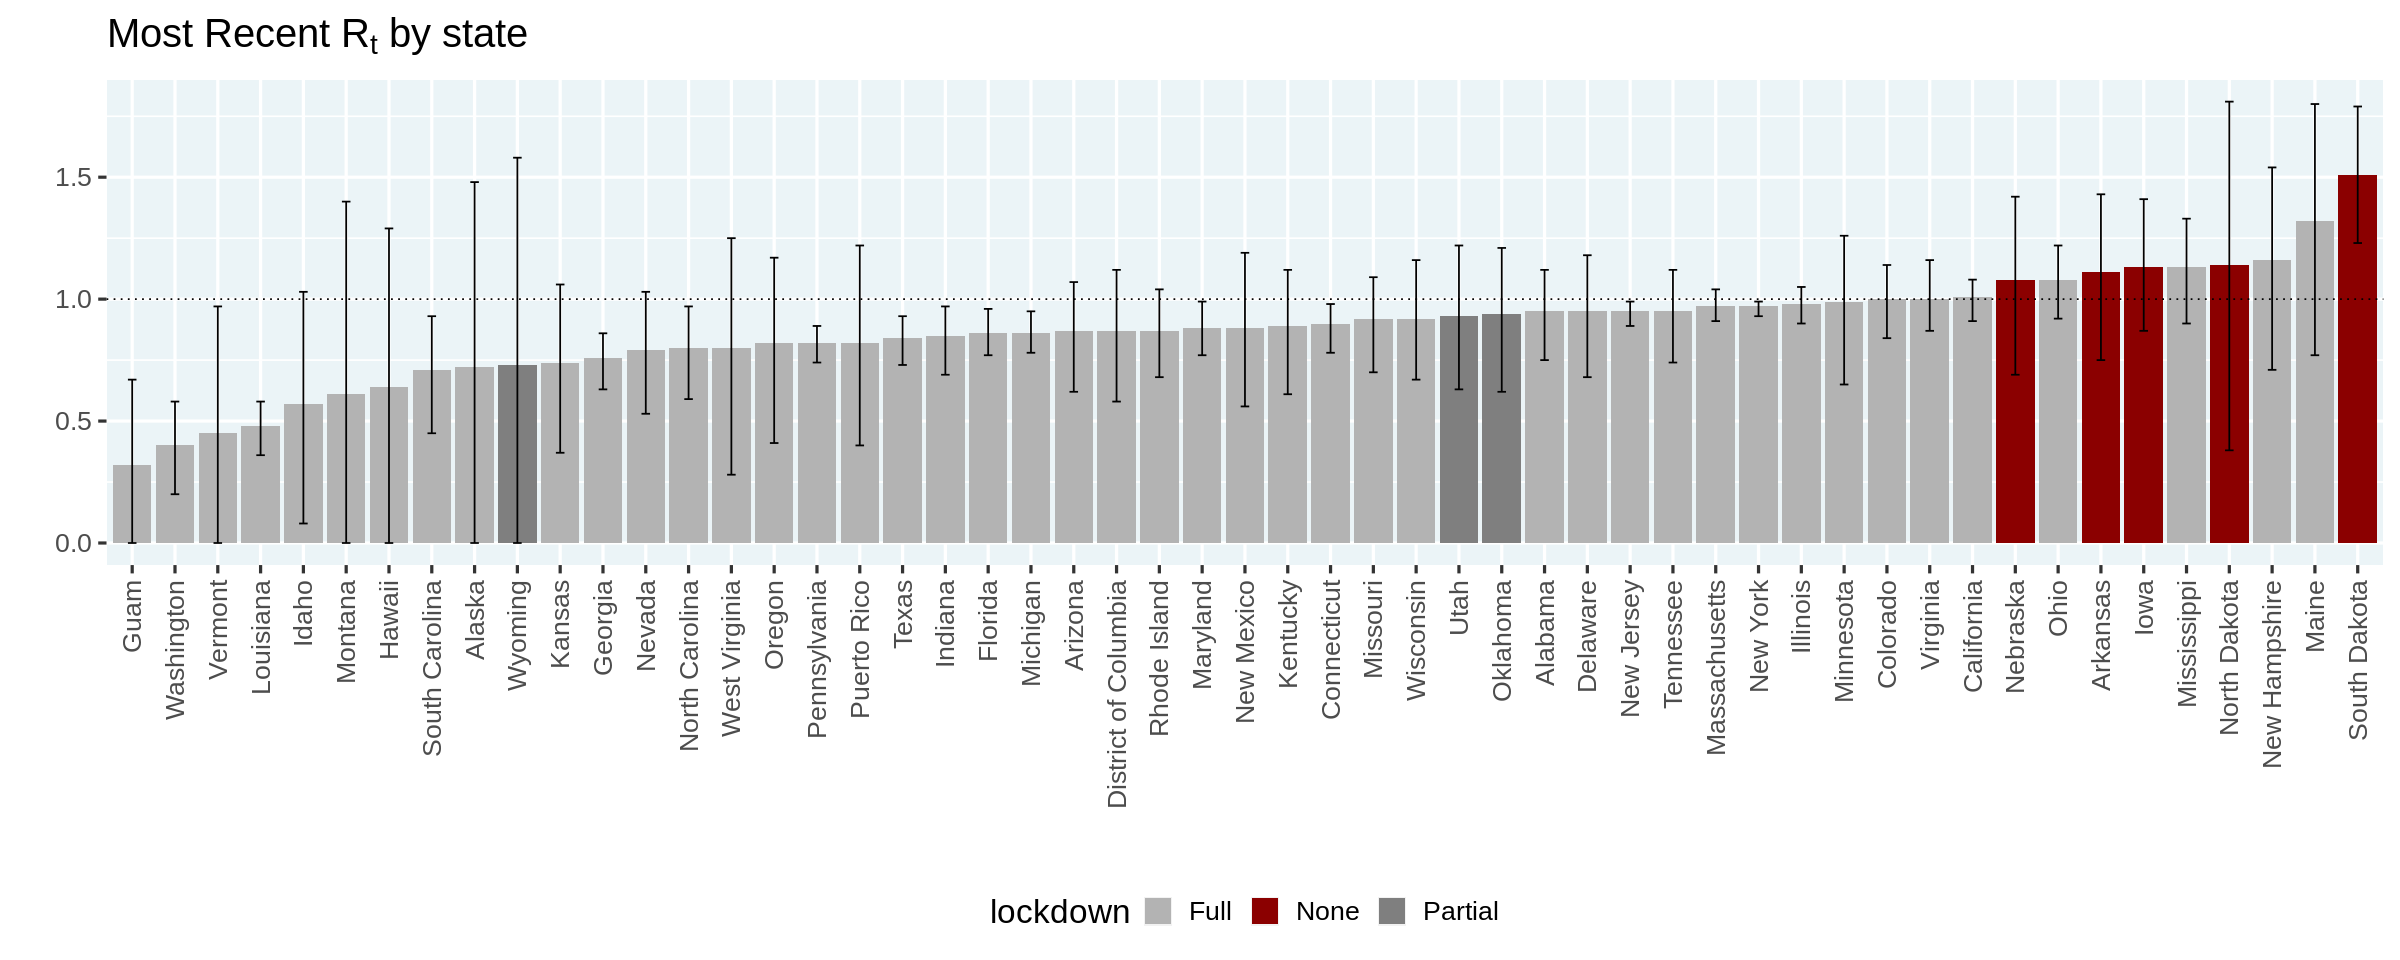

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 8)
no_lockdown = c('North Dakota', 'South Dakota', 'Nebraska', 'Iowa', 'Arkansas')
partial_lockdown = c('Utah', 'Wyoming', 'Oklahoma')
estimates_all %>%
  group_by(state) %>%
  filter(date == max(date)) %>%
  ungroup() %>%
  mutate(state = forcats::fct_reorder(state, r_t_most_likely)) %>%
  mutate(lockdown = case_when(
    state %in% no_lockdown ~ 'None',
    state %in% partial_lockdown ~ 'Partial',
    TRUE ~ "Full"
  )) %>%
  ggplot(aes(x = state, y = r_t_most_likely)) +
  geom_col(aes(fill = lockdown)) +
  geom_hline(yintercept = 1, linetype = 'dotted') +
  geom_errorbar(aes(ymin = r_t_lo, ymax = r_t_hi), width = 0.2) +
  scale_fill_manual(values = c(None = 'darkred', Partial = 'gray50', Full = 'gray70')) +
  labs(
    title = expression(paste("Most Recent R"[t], " by state")),
    x = '', y = ''
  ) +
  theme(axis.text.x.bottom = element_text(angle = 90, hjust = 1, vjust = 0.5))
options(repr.plot.width = 12, repr.plot.height = 5)

## Conclusions and Next Steps

In this article, we replicated Kevin's analysis in R, using the `tidyverse`. We learnt some useful tricks to compute likelihoods and posteriors. I learnt a ton in this process!

I can think of several next steps, but will highligting one major one that comes to mind. Given that the functions developed in this article rely on a fairly simple input table with three columns: `location`, `date`, `cases`, an interesting next step would be to turn this into an R package. This will make it easier to estimate $R_t$ for other geographies.

I would like to end by thanking [Kevin Systrom](https://twitter.com/kevin) for publishing an interesting post and sharing his code. I would also like to thank my colleagues at [DataCamp](http://dataamp.com) for their excellent feedback on an initial version of this article. 


If you have any feedback/comments on this article, or would like to suggest other extensions, you can find me on twitter [@ramnath_vaidya](https://twitter.com/ramnath_vaidya) and [github](https://github.com/ramnathv).

